In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt 
import pandas as pd
from PIL import Image
import numpy as np
import os
import shutil
import seaborn as sns



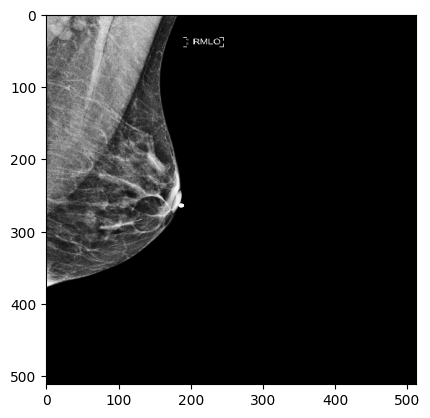

In [4]:
# img_color = cv2.imread('../ds/DARK/aug_49_mlo/test/0/1688_862827811.png',cv2.IMREAD_COLOR)
img = np.asarray(Image.open('../ds/DARK/aug_49_mlo/test/0/1688_862827811.png'))
plt.imshow(img,'gray')

In [9]:
def globalBinarise(img, thresh, maxval):
    """
    binarising the image using a threshold valueto create a binary mask 
    0: background pixel, 1: pixel breast/noise.
    """

    binarised_img = np.zeros(img.shape, np.uint8)
    binarised_img[img >= thresh] = maxval

    return binarised_img

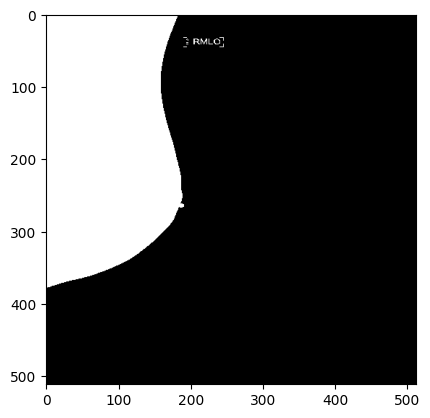

In [35]:
# img_color = cv2.imread('../ds/DARK/aug_49_mlo/test/0/1688_862827811.png',cv2.IMREAD_COLOR)
img = np.asarray(Image.open('../ds/DARK/aug_49_mlo/test/0/1688_862827811.png'))
binarised_mask = globalBinarise(img, 0.5, 10)
plt.imshow(binarised_mask,'gray')

In [41]:
def editMask(mask, ksize=(23, 23), operation="open"):
    """
    expands the white edges in the mask
    """

    kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=ksize)

    if operation == "open":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    elif operation == "close":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    edited_mask = cv2.morphologyEx(edited_mask, cv2.MORPH_DILATE, kernel)

    return edited_mask

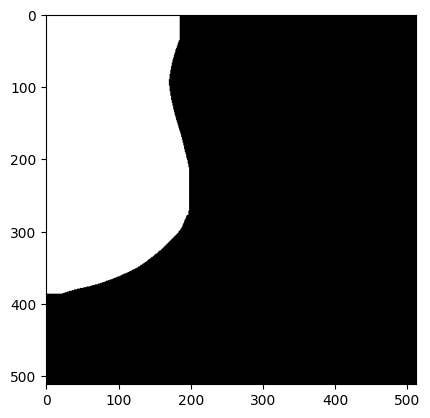

In [42]:
edited_mask = editMask(binarised_mask)
plt.imshow(edited_mask,'gray')

In [49]:
def sortContoursByArea( contours, reverse=True):
    """
    Sorting contours to detect breast contour (largest contour in the mask) 
    """

    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=reverse)

    # bounding_boxes = [cv2.boundingRect(c) for c in sorted_contours]

    bounding_boxes = []
    for contour in sorted_contours:
        bounding_boxes.append(cv2.boundingRect(contour))

    return sorted_contours, bounding_boxes

In [50]:
def xLargestBlobs(mask, top_x=None, reverse=True):
    """
    
    """
    contours, hierarchy = cv2.findContours(
        image=mask, mode=cv2.RETR_EXTERNAL, 
        method=cv2.CHAIN_APPROX_NONE
    )

    n_contours = len(contours)

    # Only get largest blob if there is at least 1 contour.
    if n_contours > 0:

        # Make sure that the number of contours to keep is at most equal
        # to the number of contours present in the mask.
        if (top_x == None):
            top_x = n_contours

        # Sort contours based on contour area.
        sorted_contours, bounding_boxes = sortContoursByArea(
            contours=contours, reverse=reverse
        )

        # Get the top X largest contours.
        X_largest_contours = sorted_contours[0:top_x]

        # Create black canvas to draw contours on.
        to_draw_on = np.zeros(mask.shape, np.uint8)

        # Draw contours in X_largest_contours.
        X_largest_blobs = cv2.drawContours(
            image=to_draw_on,  # Draw the contours on `to_draw_on`.
            contours=X_largest_contours,  # List of contours to draw.
            contourIdx=-1,  # Draw all contours in `contours`.
            color=1,  # Draw the contours in white.
            thickness=-1,  # Thickness of the contour lines.
        )

    return n_contours, X_largest_blobs

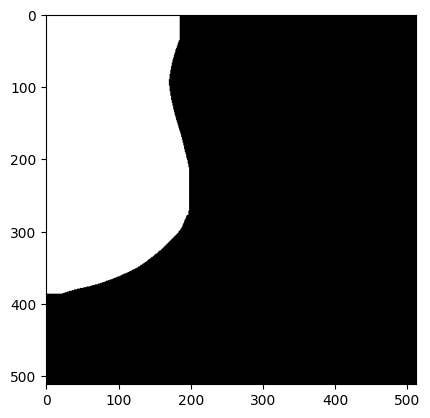

In [51]:
_, xlargest_mask = xLargestBlobs(mask=edited_mask)
plt.imshow(xlargest_mask,'gray')

In [53]:
def applyMask(img, mask):

    masked_img = img.copy()
    masked_img[mask == 0] = 0

    return masked_img

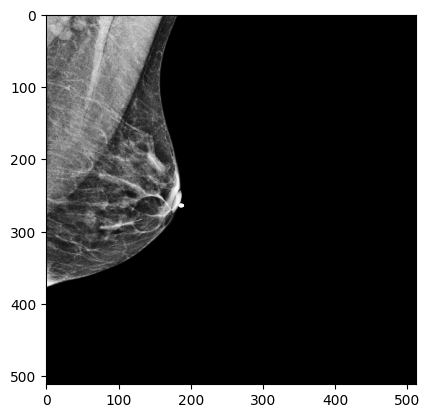

: 

In [54]:
masked_img = applyMask(img=img, mask=xlargest_mask)
plt.imshow(masked_img,'gray')

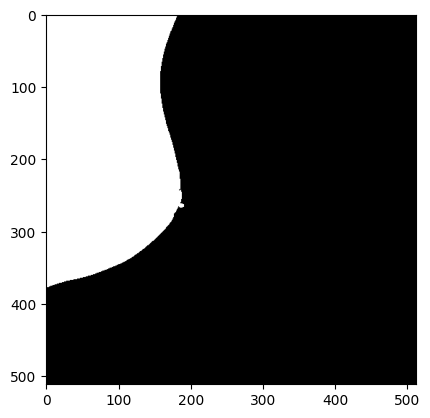

In [5]:
def crop(img):
    img_array = np.array(img)
    bin = cv2.threshold(img_array, 20, 255, cv2.THRESH_BINARY)[1]
    cnts, _ = cv2.findContours(bin.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    mask = np.zeros(img_array.shape, np.uint8)
    cv2.drawContours(mask, [cnt], -1, 255, cv2.FILLED)
    return mask


plt.imshow(crop(img),'gray')

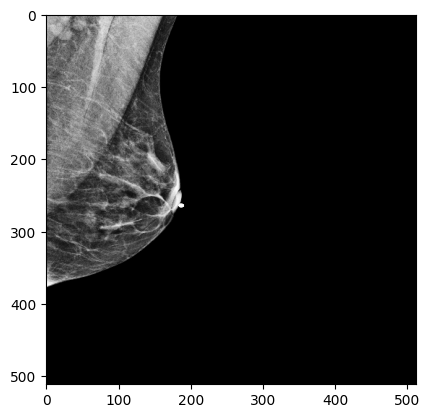

In [6]:
def applyMask(img, mask):

    masked_img = img.copy()
    masked_img[mask == 0] = 0

    return masked_img

largest_mask = crop(img)
masked_img = applyMask(img=img, mask=largest_mask)
plt.imshow(masked_img,'gray')